In [ ]:
# helpful packages to load

import numpy as np
import pandas as pd
import os
# load the data
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))              

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D
from collections import Counter
import shutil
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.utils import image_dataset_from_directory  # Or tf.keras.preprocessing.image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
dataset_path = r"C:\Users\mr saurabh\.vscode\bloodgroup_detection_using_fingerprinter\dataset"

In [ ]:
BATCH_SIZE = 64

In [ ]:
# Load the dataset
dataset2 = image_dataset_from_directory(
    dataset_path,
    labels='inferred',  # Automatically assigns labels based on subfolder names
    label_mode='int',   # Integer labels (0,1,2,... for each class)
    batch_size=BATCH_SIZE,
    image_size=(64, 64),  # Resize images to 64x64
    shuffle=True  # Shuffle data for better training
)
class_names = dataset2.class_names
print(class_names)
print("Number of classes:", len(class_names))
print("Number of batches:", len(dataset2))


Found 8010 files belonging to 9 classes.
['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-', 'train']
Number of classes: 9
Number of batches: 126


In [ ]:
# Ensure the cell at index 4 is executed before running this cell

# Step 2: check class distribution
class_names = dataset2.class_names
class_count = Counter()
for _, labels in dataset2.unbatch():
    class_count[int(labels.numpy())] += 1

print("Class distribution:")
for i, count in class_count.items():
    print(f"{class_names[i]}: {count}")

Class distribution:
B-: 1000
A+: 1001
AB+: 1000
B+: 1000
O+: 1000
O-: 1000
AB-: 1000
A-: 1009


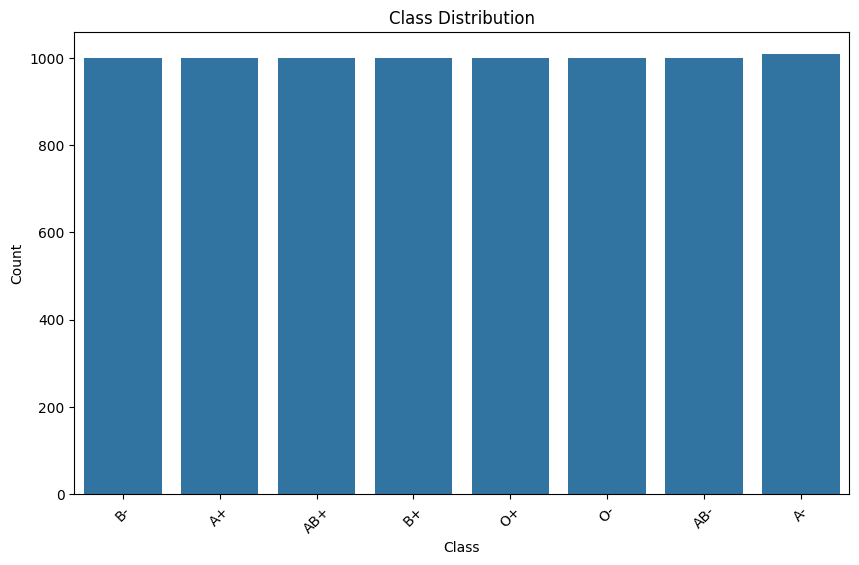

In [ ]:
# Ensure the cell defining `class_count` (CELL INDEX: 5) is executed before running this cell.

def plot_class_distribution(class_count, class_names):
    """
    Plots the distribution of classes in the dataset.
    """
    counts = [class_count[i] for i in class_count.keys()]
    classes = [class_names[i] for i in class_count.keys()]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=classes, y=counts)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Class Distribution")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(class_count, class_names)

In [ ]:
max_count = max(class_count.values())

In [ ]:
# Function to oversample a class
# Function to oversample a class
def oversample_class(class_id, count, max_count):
	# Ensure the dataset is unbatched for filtering
	unbatched_dataset = dataset2.unbatch()

	# Filter the dataset for the specific class
	class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))

	# Calculate the number of repetitions
	repeat_factor = max_count // count + (max_count % count > 0)

	# Repeat the dataset to match the desired count
	return class_dataset.repeat(repeat_factor).take(max_count)

In [ ]:
# balance the dataset
balanced_dataset = []
for class_id, count in class_count.items():
        balanced_dataset.append(oversample_class(class_id, count, max_count))


# Combine the balanced data
balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_dataset)

#check balanced class distribution
balanced_class_count = Counter([int(lbl.numpy()) for _, lbl in balanced_dataset])

# Batch the balanced dataset
balanced_dataset = balanced_dataset.batch(BATCH_SIZE,drop_remainder=True)

In [ ]:
def new_func():
    # Ensure the cell at index 10 is executed before running this cell
    for sample in balanced_dataset.take(10):
        print(sample[0].shape)

new_func()

(64, 64, 64, 3)
(64, 64, 64, 3)
(64, 64, 64, 3)
(64, 64, 64, 3)
(64, 64, 64, 3)
(64, 64, 64, 3)
(64, 64, 64, 3)
(64, 64, 64, 3)
(64, 64, 64, 3)
(64, 64, 64, 3)


In [ ]:
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size: {dataset_size}")

Total dataset size: 8064


In [ ]:
import tensorflow as tf

# Unbatch the dataset just once
balanced_dataset_unbatched = balanced_dataset.unbatch()

# Convert to list for safe reuse
all_samples = list(balanced_dataset_unbatched)
dataset_size = len(all_samples)

# Shuffle before splitting
shuffle_buffer = dataset_size
# Separate images and labels
images, labels = zip(*all_samples)

# Create a dataset from images and labels
shuffled_dataset = tf.data.Dataset.from_tensor_slices((list(images), list(labels))).shuffle(shuffle_buffer, seed=42)

# Define split ratios
train_ratio = 0.70
val_ratio = 0.20
test_ratio = 1.0 - train_ratio - val_ratio

# Compute split sizes
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)

# Perform the split
train_dataset = shuffled_dataset.take(train_size)
val_test_dataset = shuffled_dataset.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# Batch the datasets
BATCH_SIZE = 32  # Set your preferred batch size
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

# Count batches
train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

# Report sizes
print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")
print(f"Validation dataset size: {val_batch_count * BATCH_SIZE}")
print(f"Testing dataset size: {test_batch_count * BATCH_SIZE}")


Training dataset size: 5632
Validation dataset size: 1600
Testing dataset size: 800


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l2

def create_high_accuracy_model(num_classes):
    model = tf.keras.models.Sequential([
        Input(shape=(64, 64, 3)),

        tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.SpatialDropout2D(0.2),

        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.SpatialDropout2D(0.4),

        tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.SpatialDropout2D(0.4),

        tf.keras.layers.Flatten(),
    
        tf.keras.layers.Dense(128),
        tf.keras.layers.LeakyReLU(negative_slope=0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(64,),
        tf.keras.layers.LeakyReLU(negative_slope=0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy"])
    return model

# Example usage
num_classes = 8  # 8-class classification
high_acc_model = create_high_accuracy_model(num_classes)
high_acc_model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_24            │ (None, 32, 32, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_25            │ (None, 16, 16, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_26            │ (None, 8, 8, 128)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,152,392 (4.40 MB)

 Trainable params: 1,151,560 (4.39 MB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define ReduceLROnPlateau callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Monitor validation loss
    factor=0.5,            # Reduce the learning rate by a factor of 0.5
    patience=3,            # Wait for 3 epochs without improvement before reducing LR
    verbose=1,             # Print a message when the learning rate is reduced
    min_lr=1e-6            # Minimum learning rate to avoid too small values
)

# Define EarlyStopping callback to stop training when validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=5,            # Stop after 5 epochs without improvement
    verbose=1,             # Print a message when training is stopped
    restore_best_weights=True  # Restore the model weights from the best epoch
)

In [ ]:
# Train the model
history = high_acc_model.fit(
    train_dataset,
    epochs=50,  # Set the number of epochs as needed
    validation_data=val_dataset,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.2379 - loss: 2.3846 - val_accuracy: 0.6913 - val_loss: 0.8500 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.5569 - loss: 1.2074 - val_accuracy: 0.7744 - val_loss: 0.6508 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.6517 - loss: 0.9417 - val_accuracy: 0.7919 - val_loss: 0.5743 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.6841 - loss: 0.8675 - val_accuracy: 0.8100 - val_loss: 0.5210 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.7221 - loss: 0.7802 - val_accuracy: 0.7725 - val_loss: 0.5824 - learning_rate: 0.0010
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.7304 - loss: 0.7458 - val_accuracy: 0.8231 - val_loss: 0.4996 - learning_rate: 0.0010
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.7238 - l

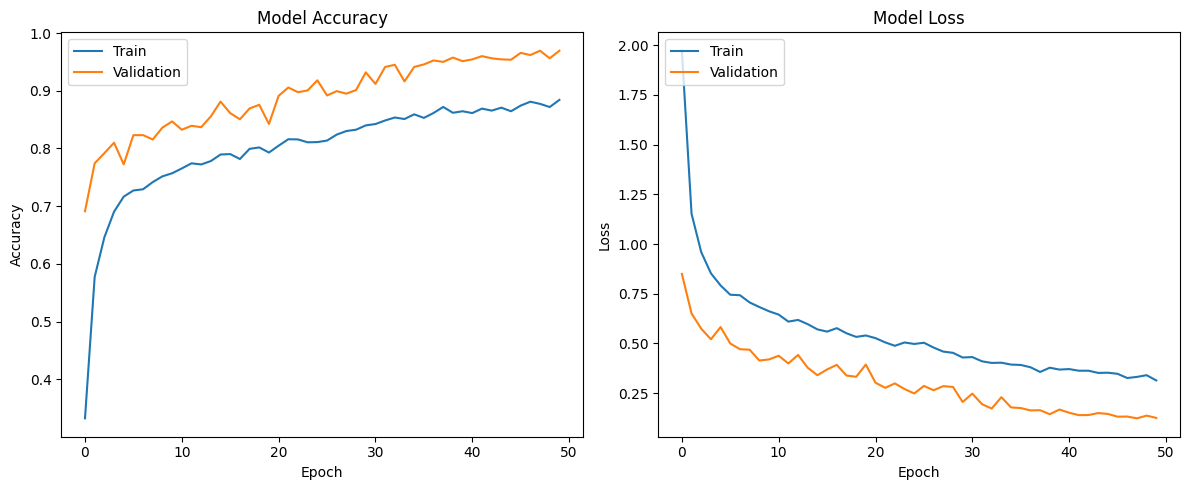

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation metrics
def plot_metrics(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_metrics(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Classification Report:
              precision    

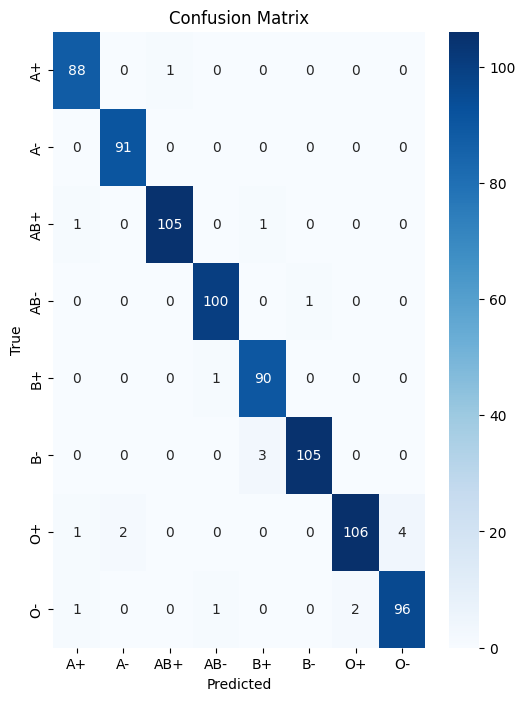

Precision: 0.98
Recall: 0.98
F1 Score: 0.98
Jaccard Index: 0.95


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Get predictions on the test dataset
y_true = []  # True labels
y_pred = []  # Predicted labels

# Iterate over the test dataset and collect the true and predicted labels
for images, labels in test_dataset:
    predictions = high_acc_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert one-hot encoded predictions to class labels
    y_true.extend(labels.numpy())  # Convert tensor to numpy array and append
    y_pred.extend(predicted_labels)  # Append the predicted labels

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
# Dynamically adjust class_names to match the unique classes in y_true
unique_classes = np.unique(y_true)
if len(unique_classes) != len(class_names):
    print("Warning: Mismatch between number of classes and class_names. Adjusting class_names.")
    adjusted_class_names = [class_names[i] if i < len(class_names) else f"Class {i}" for i in unique_classes]
else:
    adjusted_class_names = class_names

# Dynamically adjust class_names to match the unique classes in y_true
unique_classes = np.unique(y_true)
if len(unique_classes) != len(adjusted_class_names):
    print("Warning: Mismatch between number of classes and class_names. Adjusting class_names.")
    adjusted_class_names = [adjusted_class_names[i] if i < len(adjusted_class_names) else f"Class {i}" for i in unique_classes]

# Generate classification report
report = classification_report(y_true, y_pred, target_names=adjusted_class_names, labels=unique_classes)
print("Classification Report:")
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 8))
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues', xticklabels=adjusted_class_names, yticklabels=adjusted_class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, F1 score, and Jaccard index
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
jaccard = jaccard_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Jaccard Index: {jaccard:.2f}")

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import display
import numpy as np
import ipywidgets as widgets
import os

# Prediction function
def predict_blood_group(image_path, model, class_names):
    img = load_img(image_path, target_size=(64, 64))  # Resize
    img_array = img_to_array(img) / 255.0              # Normalize
    img_array = np.expand_dims(img_array, axis=0)      # Add batch dimension
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    return class_names[predicted_class]

# Upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    for filename, file_info in upload_widget.value.items():
        # Save uploaded file temporarily
        temp_path = f"temp_{filename}"
        with open(temp_path, 'wb') as f:
            f.write(file_info['content'])

        # Display the image
        display(load_img(temp_path))

        # Predict
        predicted_group = predict_blood_group(temp_path, high_acc_model, class_names)
        print(f"Predicted Blood Group: {predicted_group}")

        # Remove temporary file
        os.remove(temp_path)

# Connect the handler
upload_widget.observe(on_upload_change, names='value')
display(upload_widget)


In [ ]:
high_acc_model.save('model.h5') # Save the model to a file as "model.h5"
print("model saved to HDF5 format")

model saved to HDF5 format


In [ ]:
pip show pillow

Name: pillow
Version: 11.1.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.github.io
Author: 
Author-email: "Jeffrey A. Clark" <aclark@aclark.net>
License: MIT-CMU
Location: c:\users\mr saurabh\appdata\local\programs\python\python310\lib\site-packages
Requires: 
Required-by: matplotlib
Note: you may need to restart the kernel to use updated packages.
